In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:

path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


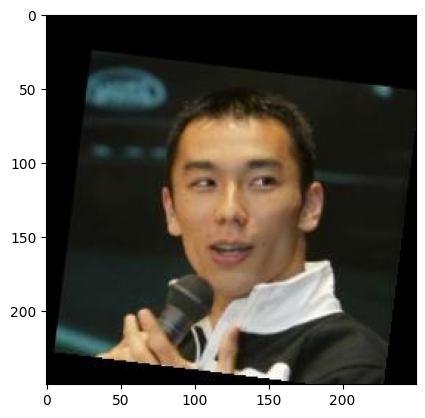

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
# Step 2: Get a sample of the data and print its dimensions
sample_image, sample_label = next(iter(dataloader))

# Dimensions of the sample image
print("Sample image shape:", sample_image.shape)
print("Sample Label:", sample_label)

# Explanation of dimensions
batch_size, channels, height, width = sample_image.shape
print("Batch size:", batch_size)
print("Number of channels (RGB):", channels)
print("Image height:", height)
print("Image width:", width)


Sample image shape: torch.Size([32, 3, 250, 250])
Sample Label: tensor([4333, 1047, 4975, 4200, 2163, 1333, 2948,  222, 5428, 1069,  783, 5312,
        4783, 2688, 5053, 4057, 3332, 5008, 3167,  385, 1871,  859, 1182,  117,
         154, 1871, 1871,  163, 4242, 4727, 5294, 4013])
Batch size: 32
Number of channels (RGB): 3
Image height: 250
Image width: 250


Batch size: This is the number of images in your batch. In your case, it's 32, as specified in your DataLoader (batch_size=32).

Number of channels (RGB): This is 3, as each image is in color and has three channels (Red, Green, Blue).

Image height: This is 250, which represents the number of pixels along the vertical axis of the image.

Image width: This is also 250, representing the number of pixels along the horizontal axis of the image.

So, the sample_image tensor has a shape of [32, 3, 250, 250], indicating a batch of 32 color images, each with dimensions 250x250 pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        # Encoder
        self.encoder_layer = self.__build_encoder()
        # Decoder
        self.decoder_layer = self.__build_decoder()

    def __build_encoder(self):
        return nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=2),  # (N, 16, 126, 126)
            nn.ReLU(),
            nn.Conv2d(16, 64, kernel_size=5, stride=2, padding=2),  # (N, 64, 63, 63)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # (N, 128, 32, 32)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Additional layer
            nn.ReLU()
        )

    def __build_decoder(self):
        return nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Additional layer
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2),  # (N, 64, 63,63)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, kernel_size=5, stride=2, padding=2, output_padding=1),  # (N, 16, 126, 126)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=2),  # (N,3, 250, 250)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder_layer(x)
        x = self.decoder_layer(x)
        return x

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
# Instantiate the Autoencoder model
# model = AE()

In [11]:
# Create an instance of the model
model = AE()

# Get a batch of images from the DataLoader
for images, _ in dataloader:
    # Check the shape of the output from the encoder and decoder
    output_of_encoder = model.encoder_layer(images)
    print(output_of_encoder.shape)

    output_of_decoder = model.decoder_layer(output_of_encoder)
    print(output_of_decoder.shape)

    forward_completed = model(images)
    print(forward_completed.shape)

    break  # Breaking the loop after processing the first batch


torch.Size([32, 256, 16, 16])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [12]:
# Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

# # Loss function
# criterion = nn.MSELoss()  # Mean Squared Error (MSE) Loss is commonly used for image reconstruction tasks

# Optimizer
learning_rate = 0.001


Total number of parameters in the model: 1052499


In [13]:
import torch.optim as optim

# Loss function
loss_function = nn.MSELoss()

# Optimizer
optim = optim.Adam(model.parameters(), lr=learning_rate)


In [14]:
# loss_function = nn.SmoothL1Loss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

In [22]:
num_epochs = 350
for epoch in range(num_epochs):
    total_loss = 0
    for x,y in dataloader:
        # ===================forward=====================
        decoded_images = model.forward(x)
        loss = loss_function(decoded_images, x)

        # ===================backward====================

        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('Epoch - {}/{}, loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
        pic = to_img(decoded_images.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

Epoch - 1/350, loss:0.0061
Epoch - 2/350, loss:0.0060
Epoch - 3/350, loss:0.0051
Epoch - 4/350, loss:0.0055
Epoch - 5/350, loss:0.0052
Epoch - 6/350, loss:0.0056
Epoch - 7/350, loss:0.0053
Epoch - 8/350, loss:0.0064
Epoch - 9/350, loss:0.0058
Epoch - 10/350, loss:0.0051
Epoch - 11/350, loss:0.0057
Epoch - 12/350, loss:0.0051
Epoch - 13/350, loss:0.0057
Epoch - 14/350, loss:0.0047
Epoch - 15/350, loss:0.0047
Epoch - 16/350, loss:0.0056
Epoch - 17/350, loss:0.0054
Epoch - 18/350, loss:0.0050
Epoch - 19/350, loss:0.0052
Epoch - 20/350, loss:0.0048
Epoch - 21/350, loss:0.0050
Epoch - 22/350, loss:0.0044
Epoch - 23/350, loss:0.0049
Epoch - 24/350, loss:0.0051
Epoch - 25/350, loss:0.0056
Epoch - 26/350, loss:0.0051
Epoch - 27/350, loss:0.0050
Epoch - 28/350, loss:0.0048
Epoch - 29/350, loss:0.0048
Epoch - 30/350, loss:0.0045
Epoch - 31/350, loss:0.0044
Epoch - 32/350, loss:0.0049
Epoch - 33/350, loss:0.0044
Epoch - 34/350, loss:0.0047
Epoch - 35/350, loss:0.0048
Epoch - 36/350, loss:0.0055
E

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

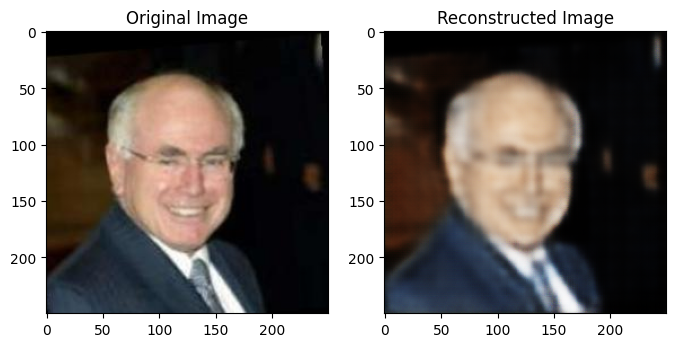

In [23]:
for images, _ in dataloader:
    original_image = images[21]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np)
    axes[1].set_title('Reconstructed Image')

    break

# Show the plot outside the loop
plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

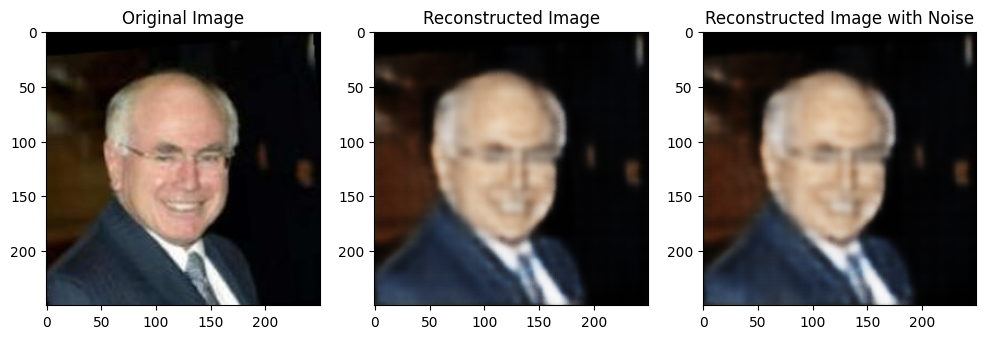

In [24]:
import torch.nn.functional as F

# Add a small normally distributed noise to the latent representation
latent_representation = model.encoder_layer(original_image.unsqueeze(0))
noise = torch.randn_like(latent_representation) * 0.1  # You can adjust the noise level
noisy_latent_representation = latent_representation + noise

# Decode the noised latent representation
with torch.no_grad():
    reconstructed_noisy_image = model.decoder_layer(noisy_latent_representation)

# Convert tensors to numpy arrays for visualization
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the original, reconstructed, and reconstructed with noise images side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

axes[2].imshow(reconstructed_noisy_image_np)
axes[2].set_title('Reconstructed Image with Noise')

plt.show()
